In [5]:
%pip install opencv-python-headless matplotlib scikit-image

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

# Helper for displaying images in VS Code / Jupyter notebooks
def show_img(img, title=None, cmap='gray'):
    if img is None:
        print('Image is None')
        return
    plt.figure(figsize=(8,6))
    if len(img.shape) == 2:
        plt.imshow(img, cmap=cmap)
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

In [ ]:
# Select an image file using a local file dialog (works in VS Code/Jupyter).
# If you cancel the dialog, the code will fall back to 'image8c.png' in the workspace.
import tkinter as tk
from tkinter import filedialog
root = tk.Tk()
root.withdraw()  # hide the main window
image_path = filedialog.askopenfilename(title='Select image', filetypes=[('Image files', '*.png;*.jpg;*.jpeg;*.tif;*.bmp')])
# fallback to a known image in the workspace if no selection is made
if not image_path:
    fallback = os.path.join(os.getcwd(), 'image8c.png')
    if os.path.exists(fallback):
        print(f'No file selected — using fallback: {fallback}')
        image_path = fallback
    else:
        raise SystemExit('No file selected and no fallback found.')
img = cv2.imread(image_path)
if img is None:
    raise SystemExit(f'Failed to read image: {image_path}')

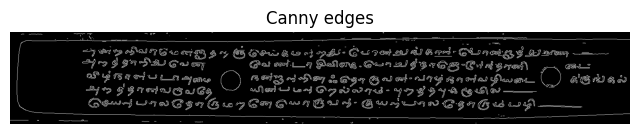

In [8]:
imgcanny = cv2.Canny(img, 150, 200)
show_img(imgcanny, title='Canny edges')

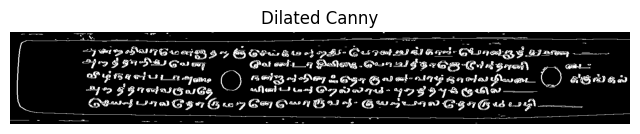

In [9]:
kernel=np.ones((1,2),np.uint8)
imgdilate=cv2.dilate(imgcanny,kernel,iterations=2)
show_img(imgdilate, title='Dilated Canny')

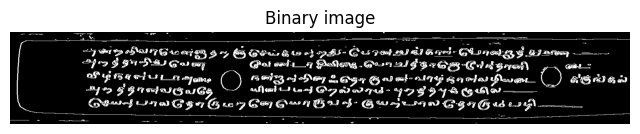

In [10]:
ret, imgbin = cv2.threshold(imgdilate, 127, 255, cv2.THRESH_BINARY)
show_img(imgbin, title='Binary image')


Original Binary Image:


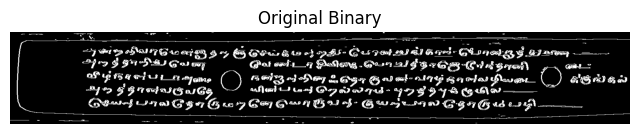

Original Binary Image:


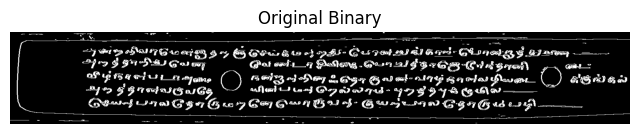


Cleaned Image (Contour Analysis):


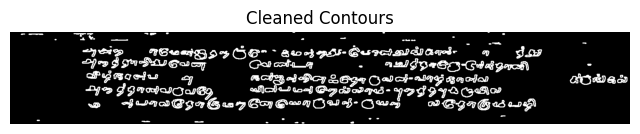

In [11]:
# Contour filtering and cleaning (works with single-channel binary images)
img_for_contours = imgbin.copy()  # Work on a copy

# Find contours (OpenCV returns contours differently depending on version)
contours_info = cv2.findContours(img_for_contours, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours_info[0] if len(contours_info) == 2 else contours_info[1]

# Create a blank image to draw the filtered contours on
cleaned_contour_image = np.zeros_like(imgbin)

# Parameters for filtering contours (tune these!)
min_area = 1
max_area = 5000
min_width = 1
max_width = 50
min_height = 1
max_height = 95

filtered_contours = []
for contour in contours:
    area = cv2.contourArea(contour)
    x, y, w, h = cv2.boundingRect(contour)
    if (min_area < area < max_area) and (min_width < w < max_width) and (min_height < h < max_height):
        filtered_contours.append(contour)

cv2.drawContours(cleaned_contour_image, filtered_contours, -1, (255), thickness=2)
print('Original Binary Image:')
show_img(imgbin, title='Original Binary')
print('\nCleaned Image (Contour Analysis):')
show_img(cleaned_contour_image, title='Cleaned Contours')

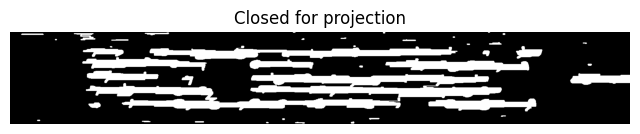

In [12]:
# Parameter for closing small horizontal gaps in lines before projection
LINE_CLOSING_KERNEL_WIDTH = 50

temp_opening_kernel = np.ones((1, LINE_CLOSING_KERNEL_WIDTH), np.uint8)
temp_cleaned_image_for_projection = cv2.morphologyEx(cleaned_contour_image, cv2.MORPH_CLOSE, temp_opening_kernel)

show_img(temp_cleaned_image_for_projection, title='Closed for projection')

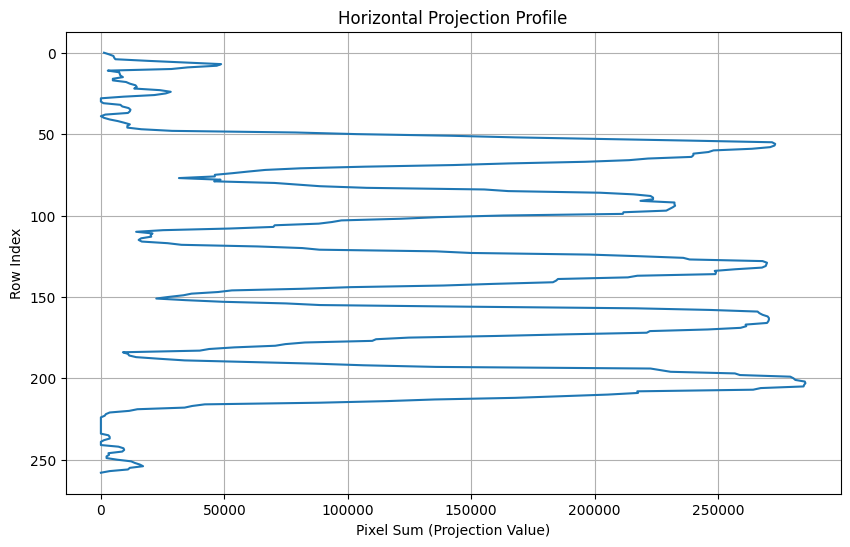

Horizontal Projection Profile (first 20 values): [ 1275  3315  5100  5355  5865 19125 34170 48705 46920 35190 28560  2805
  7395  7650  7905  8925  4845  4845 10200 11730]


In [13]:
horizontal_projection = np.sum(temp_cleaned_image_for_projection, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(horizontal_projection, range(len(horizontal_projection)))
plt.gca().invert_yaxis() # Invert y-axis to match image orientation
plt.xlabel("Pixel Sum (Projection Value)")
plt.ylabel("Row Index")
plt.title("Horizontal Projection Profile")
plt.grid(True)
plt.show()

print("Horizontal Projection Profile (first 20 values):", horizontal_projection[:20])

In [14]:
# Parameter for horizontal projection threshold
LINE_SEGMENTATION_THRESHOLD_MULTIPLIER = 1.1# Increase this value to be more aggressive in merging lines, decrease to split lines more easily

threshold_projection = np.mean(horizontal_projection[horizontal_projection > 0]) * LINE_SEGMENTATION_THRESHOLD_MULTIPLIER # A dynamic threshold

line_starts = []
line_ends = []
is_in_line = False

for i, value in enumerate(horizontal_projection):
    if value > threshold_projection and not is_in_line:
        line_starts.append(i)
        is_in_line = True
    elif value <= threshold_projection and is_in_line:
        # Ensure we don't end a line prematurely due to small gaps
        # Look ahead to see if there are significant non-zero values soon after
        # For simplicity in this first pass, we'll use a direct end. Refinement can be added later.
        line_ends.append(i - 1) # The line ended at the previous row
        is_in_line = False

# Handle the case where the last line extends to the end of the image
if is_in_line:
    line_ends.append(len(horizontal_projection) - 1)

print("Identified Line Starts:", line_starts)
print("Identified Line Ends:", line_ends)

Identified Line Starts: [51, 84, 122, 156, 193]
Identified Line Ends: [69, 101, 143, 174, 213]


Segmented Line 1:


Segmented Line 1:


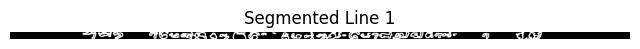

Segmented Line 1:


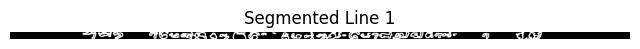

Segmented Line 2:


Segmented Line 1:


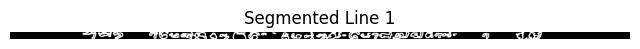

Segmented Line 2:


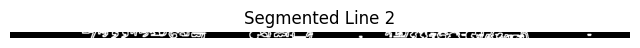

Segmented Line 1:


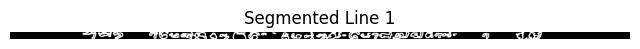

Segmented Line 2:


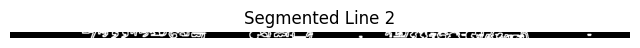

Segmented Line 3:


Segmented Line 1:


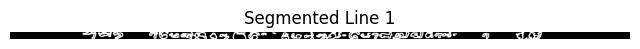

Segmented Line 2:


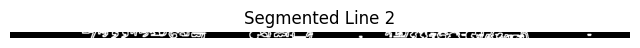

Segmented Line 3:


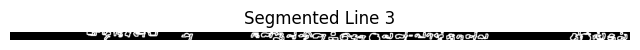

Segmented Line 1:


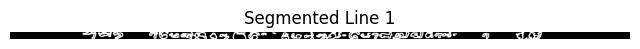

Segmented Line 2:


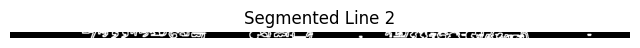

Segmented Line 3:


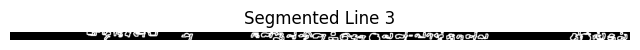

Segmented Line 4:


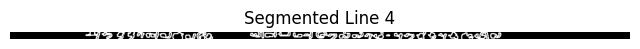

Segmented Line 1:


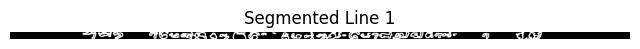

Segmented Line 2:


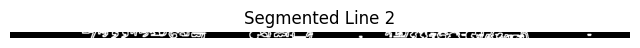

Segmented Line 3:


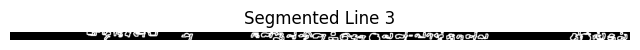

Segmented Line 4:


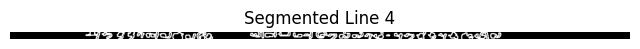

Segmented Line 5:


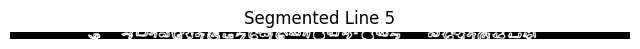

In [15]:
separated_lines = []

for i in range(len(line_starts)):
    start_y = line_starts[i]
    end_y = line_ends[i]
    line_img = cleaned_contour_image[start_y:end_y+1, :]
    separated_lines.append(line_img)
    print(f'Segmented Line {i+1}:')
    show_img(line_img, title=f'Segmented Line {i+1}')

Segmented Line 1 (from original image):


Segmented Line 1 (from original image):


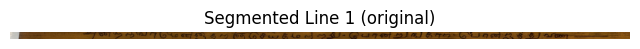

Segmented Line 1 (from original image):


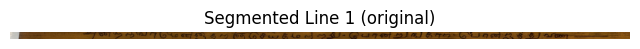

Segmented Line 2 (from original image):


Segmented Line 1 (from original image):


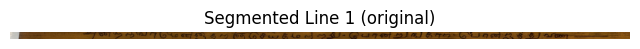

Segmented Line 2 (from original image):


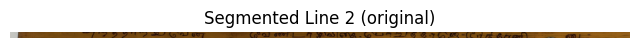

Segmented Line 1 (from original image):


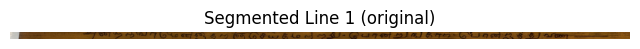

Segmented Line 2 (from original image):


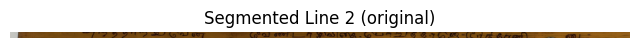

Segmented Line 3 (from original image):


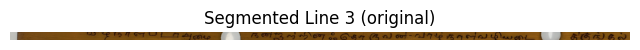

Segmented Line 1 (from original image):


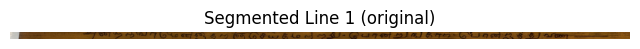

Segmented Line 2 (from original image):


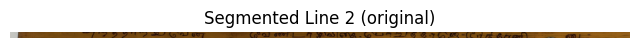

Segmented Line 3 (from original image):


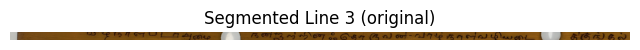

Segmented Line 4 (from original image):


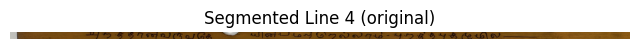

Segmented Line 1 (from original image):


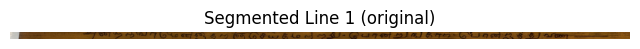

Segmented Line 2 (from original image):


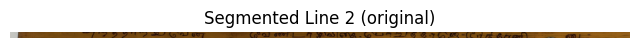

Segmented Line 3 (from original image):


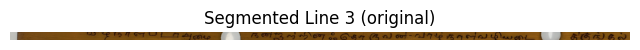

Segmented Line 4 (from original image):


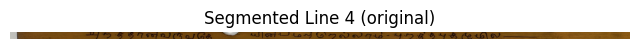

Segmented Line 5 (from original image):


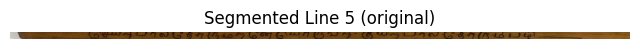

In [16]:
separated_lines_original = []

for i in range(len(line_starts)):
    start_y = line_starts[i]
    end_y = line_ends[i]

    line_img_original = img[start_y:end_y+1, :]
    separated_lines_original.append(line_img_original)
    print(f'Segmented Line {i+1} (from original image):')
    show_img(line_img_original, title=f'Segmented Line {i+1} (original)')


Segmented Characters/Words:


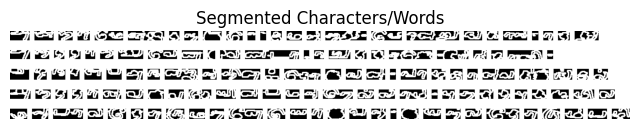

In [17]:
separated_characters_words_per_line = []
display_segments = [] # To store segments for combined display

# Parameters for segmentation
MIN_SEGMENT_WIDTH = 5 # Minimum width for a valid character/word segment. Increase to filter out smaller noise.
CHAR_SEGMENTATION_THRESHOLD_MULTIPLIER = 0.05 # Increase this value to merge characters/words more easily, decrease to split them more aggressively.

for line_idx, line_img in enumerate(separated_lines):
    if line_img.shape[1] == 0: # Skip empty lines
        print(f"Skipping empty line {line_idx+1}")
        continue

    # Calculate vertical projection profile
    vertical_projection = np.sum(line_img, axis=0)

    # Dynamic thresholding for segmentation
    non_zero_projections = vertical_projection[vertical_projection > 0]
    if non_zero_projections.size > 0:
        # Use a fraction of the average non-zero projection as a threshold
        threshold_for_segmentation = np.mean(non_zero_projections) * CHAR_SEGMENTATION_THRESHOLD_MULTIPLIER
    else:
        threshold_for_segmentation = 0 # No content, so threshold is 0

    current_line_segments = []
    is_in_segment = False
    start_col = 0

    for col_idx, value in enumerate(vertical_projection):
        if value > threshold_for_segmentation and not is_in_segment:
            # Start of a new segment
            start_col = col_idx
            is_in_segment = True
        elif value <= threshold_for_segmentation and is_in_segment:
            # End of a segment
            end_col = col_idx - 1
            if (end_col - start_col + 1) >= MIN_SEGMENT_WIDTH:
                segment = line_img[:, start_col : end_col + 1]
                current_line_segments.append(segment)
            is_in_segment = False

    # Handle the case where the last segment extends to the end of the line
    if is_in_segment:
        end_col = len(vertical_projection) - 1
        if (end_col - start_col + 1) >= MIN_SEGMENT_WIDTH:
            segment = line_img[:, start_col : end_col + 1]
            current_line_segments.append(segment)

    separated_characters_words_per_line.append(current_line_segments)

    # For display, combine segments with a separator
    if current_line_segments:
        # Create a white separator (grayscale as line_img is grayscale)
        separator_width = 10
        separator = np.full((line_img.shape[0], separator_width), 255, dtype=np.uint8)

        combined_segments_image_line = []
        for i, segment in enumerate(current_line_segments):
            combined_segments_image_line.append(segment)
            if i < len(current_line_segments) - 1:
                combined_segments_image_line.append(separator)

        if combined_segments_image_line:
            display_segments.append(np.concatenate(combined_segments_image_line, axis=1))

# Now display all the combined line segments
if display_segments:
    # Add a small vertical separator between lines for clarity in the final display
    line_separator_height = 20
    max_width = max([img.shape[1] for img in display_segments])
    line_separator = np.full((line_separator_height, max_width), 255, dtype=np.uint8)

    final_display_images = []
    for i, line_segments_img in enumerate(display_segments):
        # Pad shorter lines to max_width
        if line_segments_img.shape[1] < max_width:
            padding = np.full((line_segments_img.shape[0], max_width - line_segments_img.shape[1]), 255, dtype=np.uint8)
            line_segments_img = np.concatenate((line_segments_img, padding), axis=1)

        final_display_images.append(line_segments_img)
        if i < len(display_segments) - 1:
            final_display_images.append(line_separator)

    combined_all_segments_image = np.concatenate(final_display_images, axis=0)
    print('\nSegmented Characters/Words:')
    show_img(combined_all_segments_image, title='Segmented Characters/Words')
else:
    print("No characters or words were segmented.")

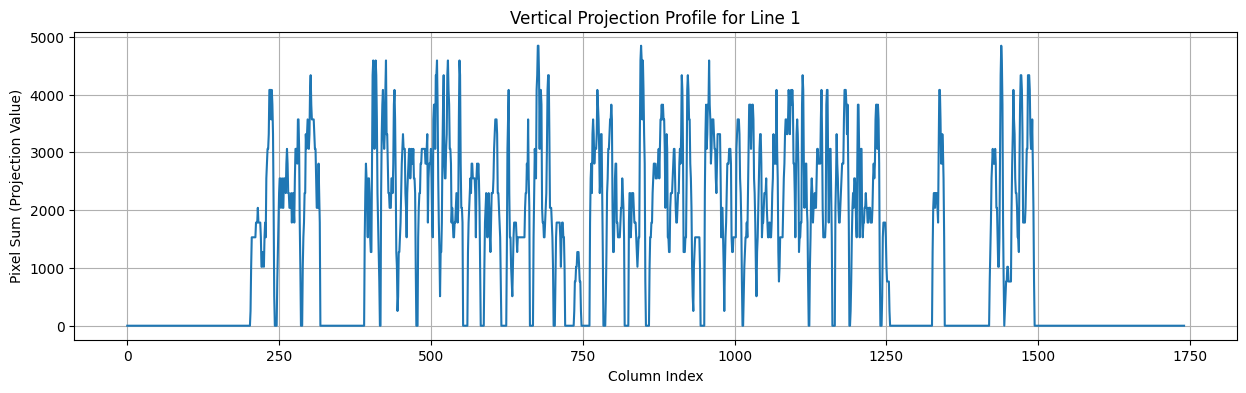

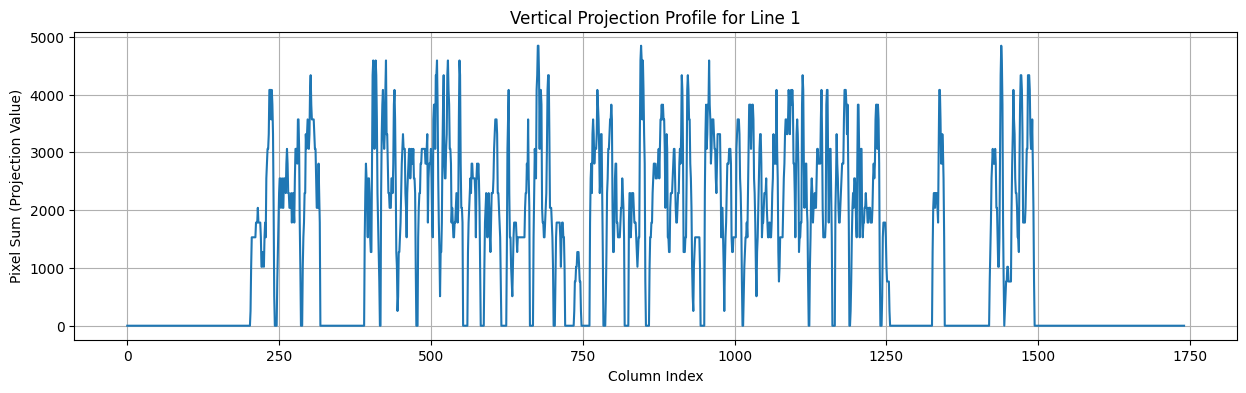

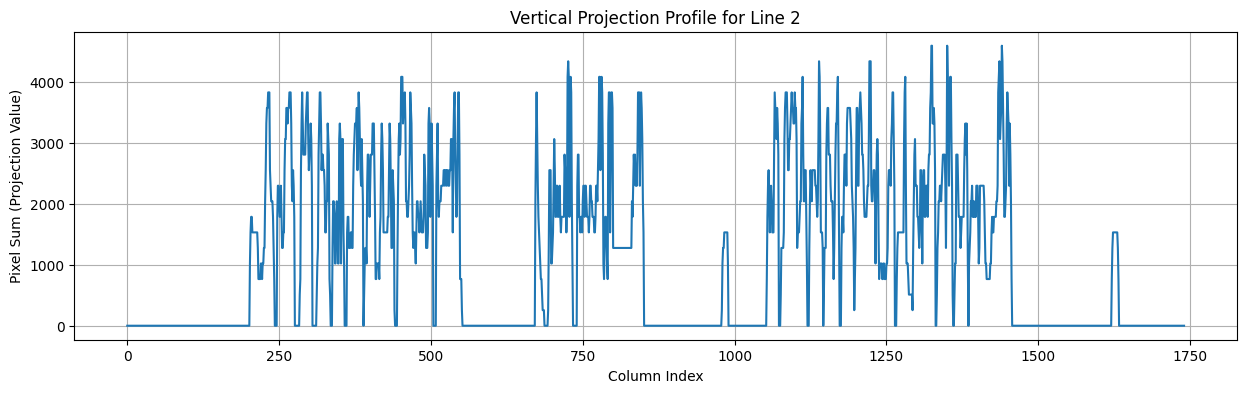

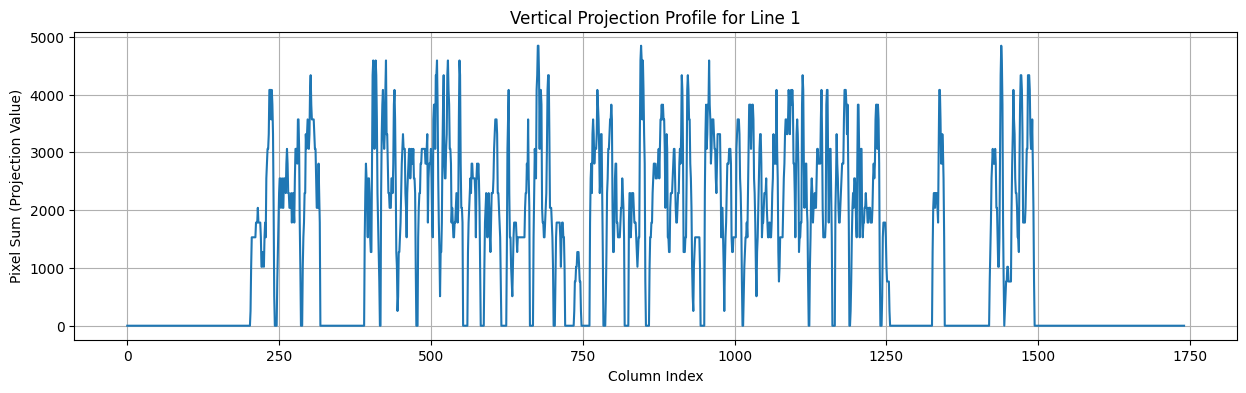

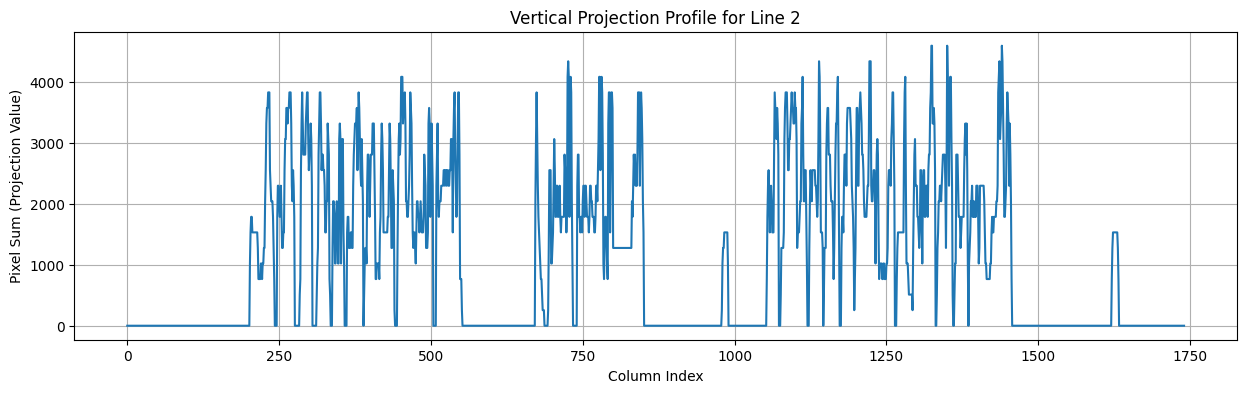

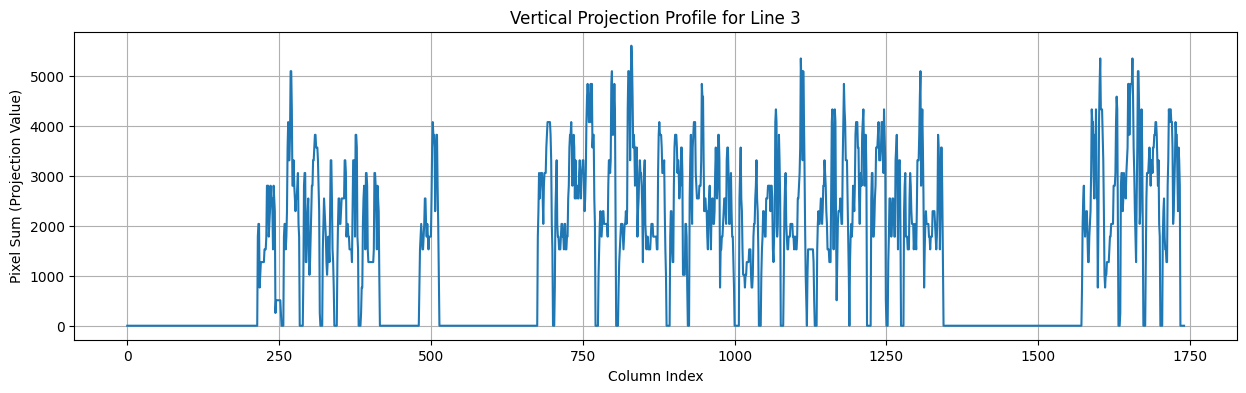

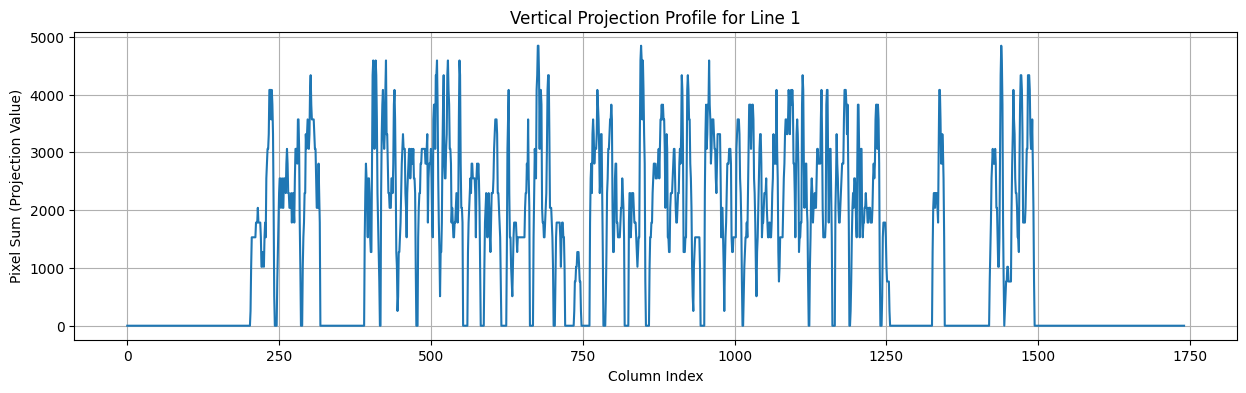

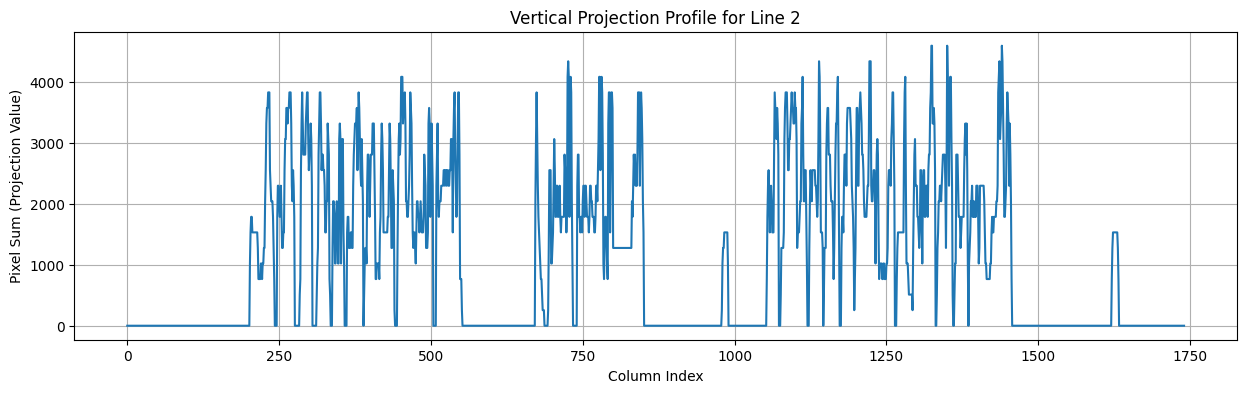

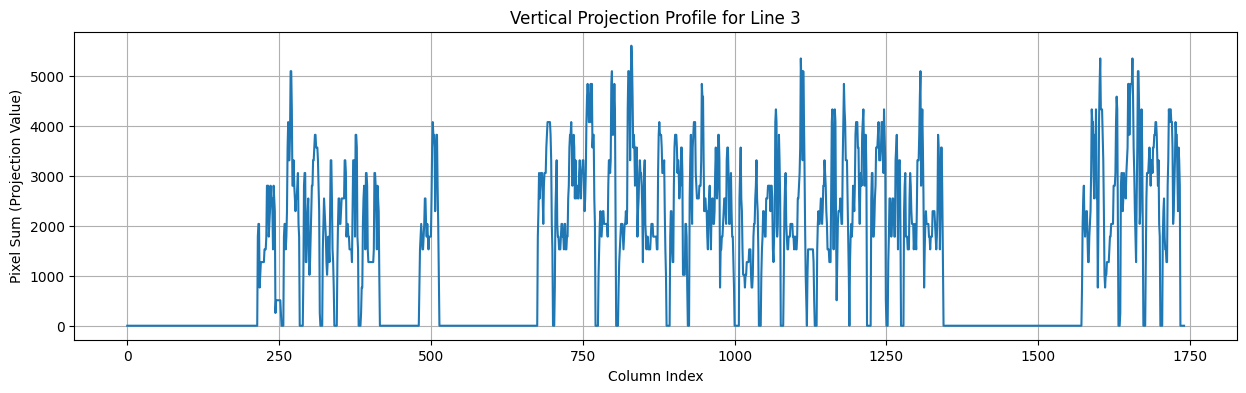

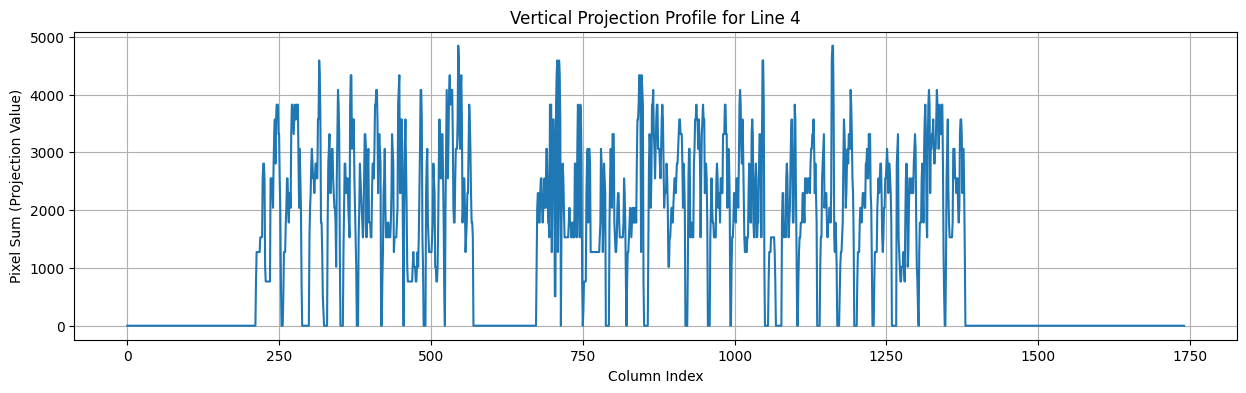

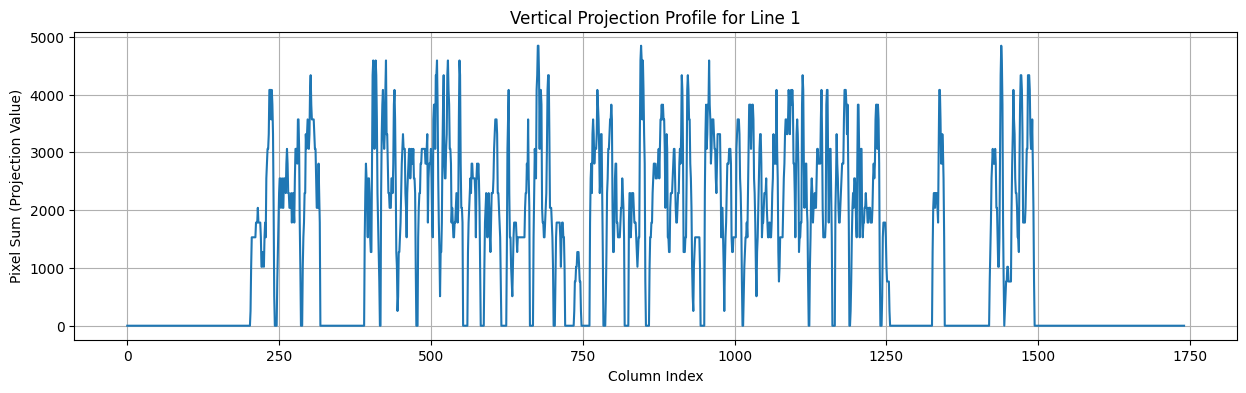

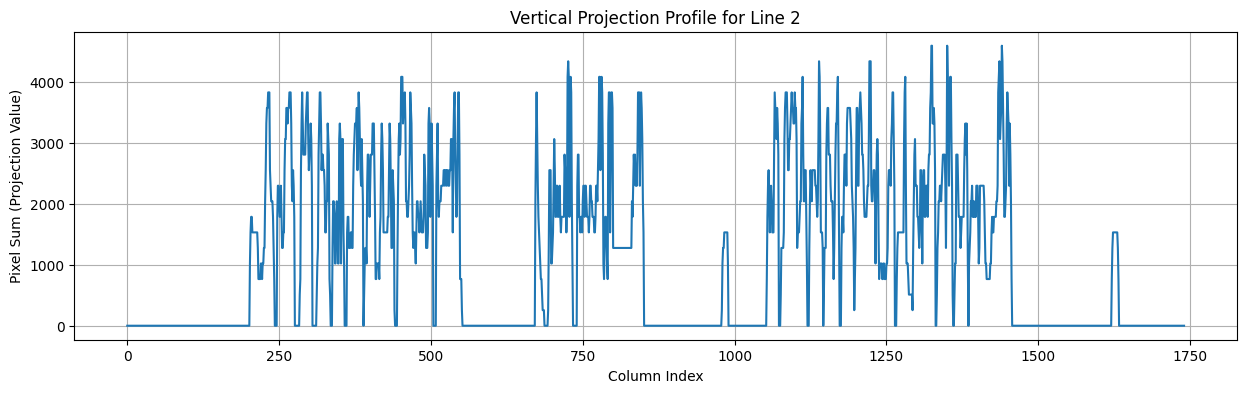

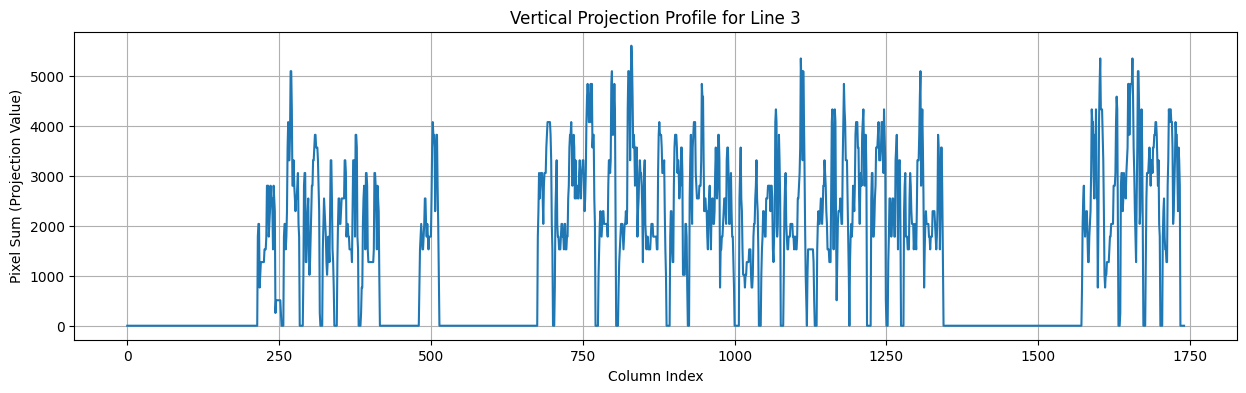

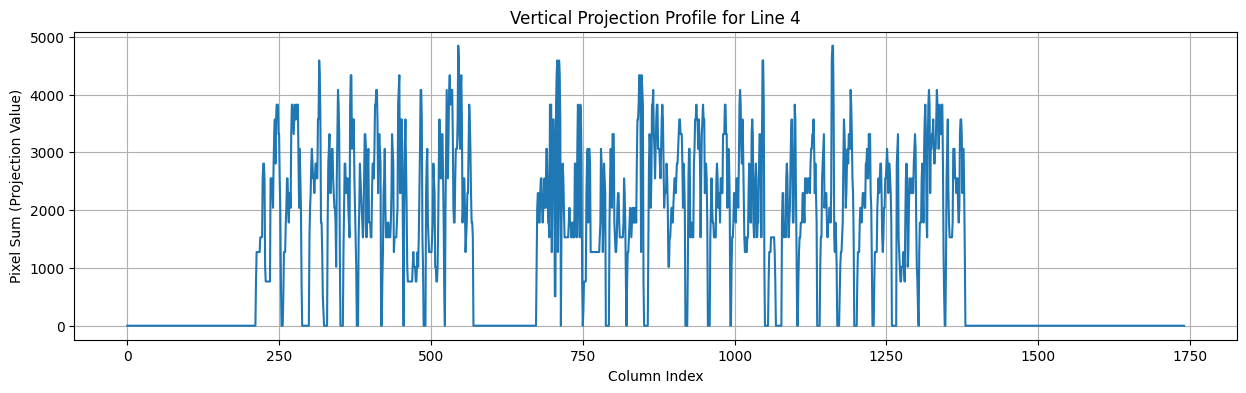

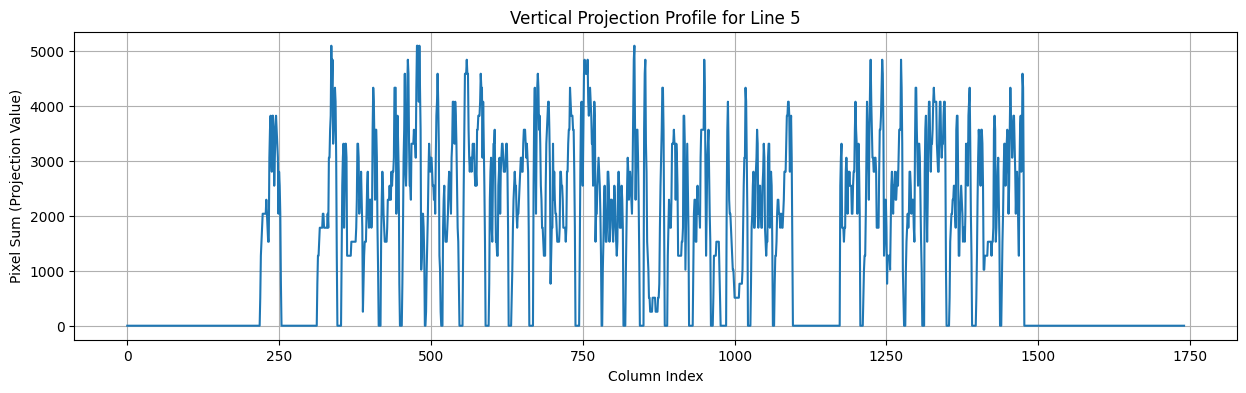

In [18]:
import matplotlib.pyplot as plt

# Loop through each separated line and plot its vertical projection
for line_idx, line_img_binary in enumerate(separated_lines):
    if line_img_binary.shape[1] == 0:
        print(f"Skipping vertical projection for empty line {line_idx+1}")
        continue

    vertical_projection = np.sum(line_img_binary, axis=0)

    plt.figure(figsize=(15, 4))
    plt.plot(vertical_projection)
    plt.xlabel("Column Index")
    plt.ylabel("Pixel Sum (Projection Value)")
    plt.title(f"Vertical Projection Profile for Line {line_idx+1}")
    plt.grid(True)
    plt.show()

Extracted 5 lines of character/word segments from the original image.
First few character/word segments from the first line (original image):
Segment 1 shape: (19, 40, 3)


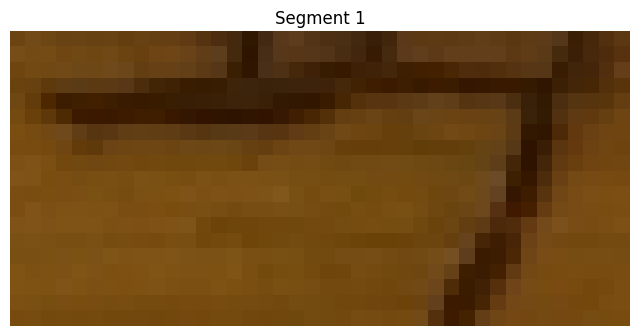

Extracted 5 lines of character/word segments from the original image.
First few character/word segments from the first line (original image):
Segment 1 shape: (19, 40, 3)


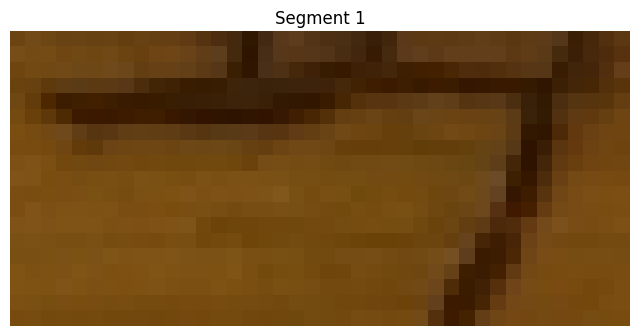

Segment 2 shape: (19, 39, 3)


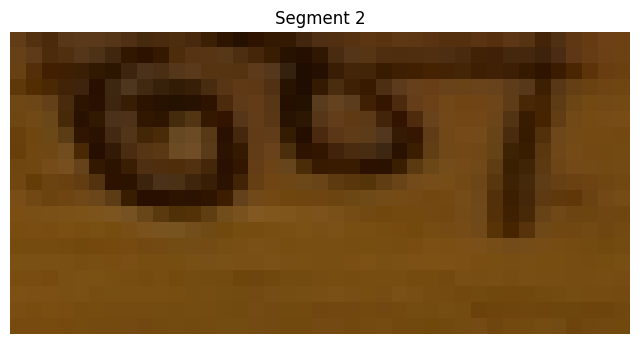

Extracted 5 lines of character/word segments from the original image.
First few character/word segments from the first line (original image):
Segment 1 shape: (19, 40, 3)


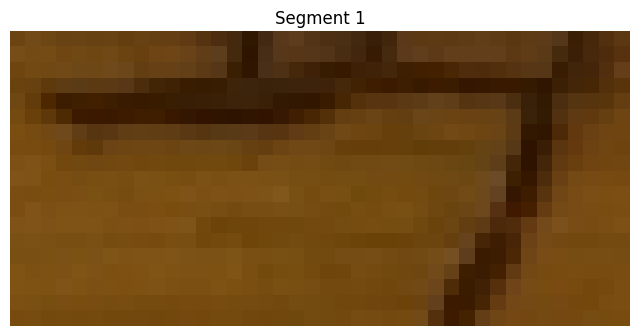

Segment 2 shape: (19, 39, 3)


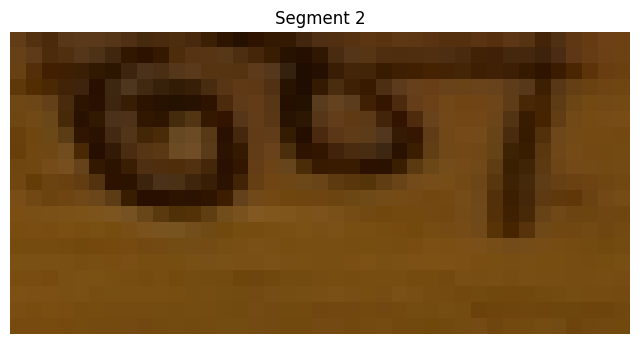

Segment 3 shape: (19, 29, 3)


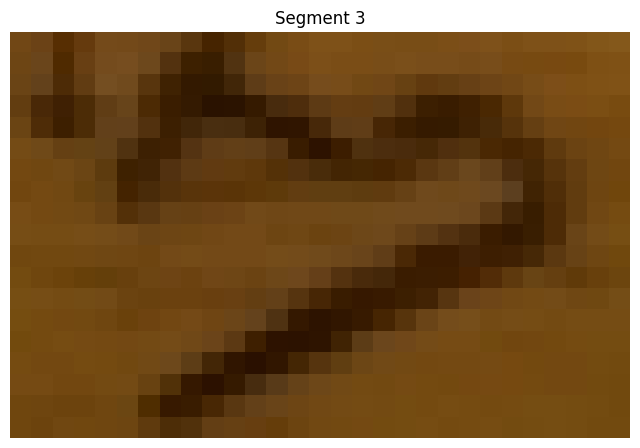

Extracted 5 lines of character/word segments from the original image.
First few character/word segments from the first line (original image):
Segment 1 shape: (19, 40, 3)


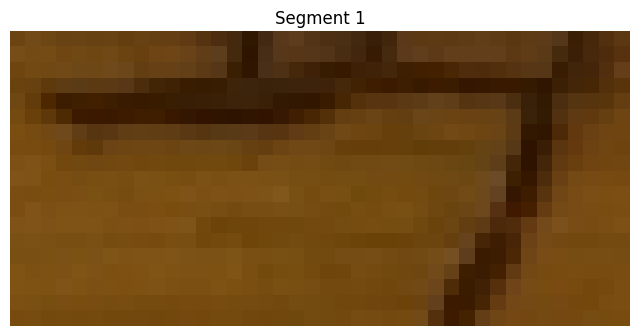

Segment 2 shape: (19, 39, 3)


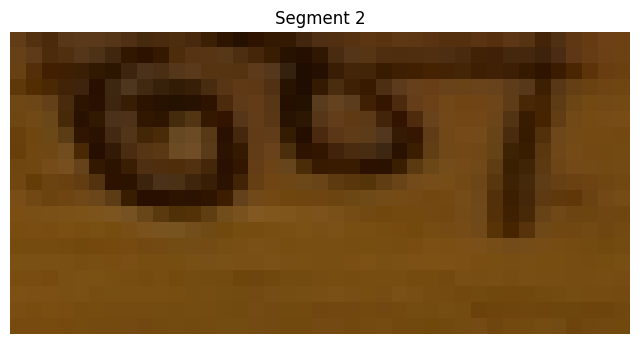

Segment 3 shape: (19, 29, 3)


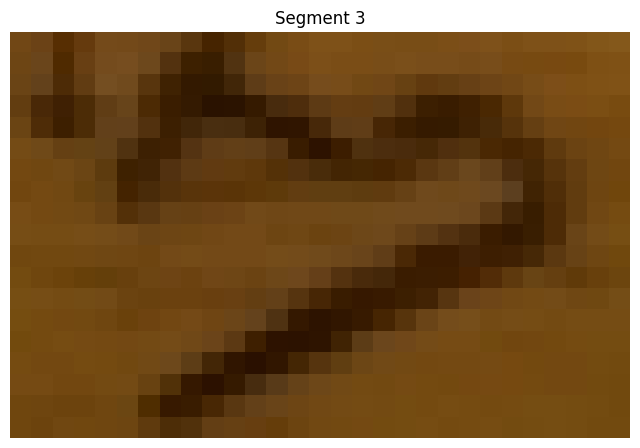

Segment 4 shape: (19, 25, 3)


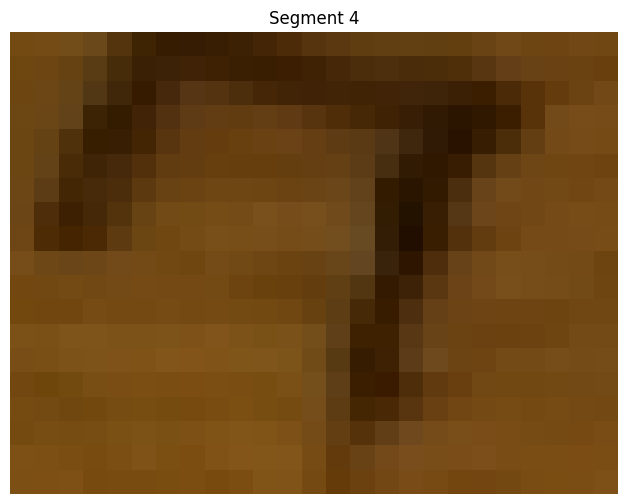

Extracted 5 lines of character/word segments from the original image.
First few character/word segments from the first line (original image):
Segment 1 shape: (19, 40, 3)


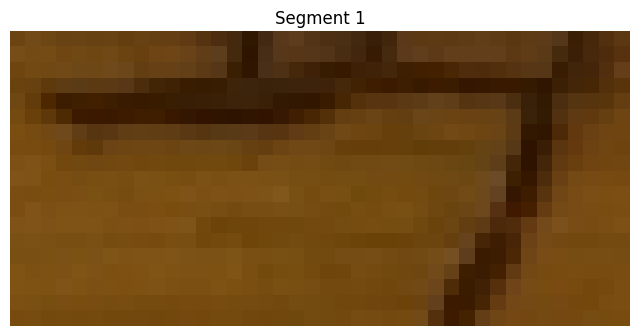

Segment 2 shape: (19, 39, 3)


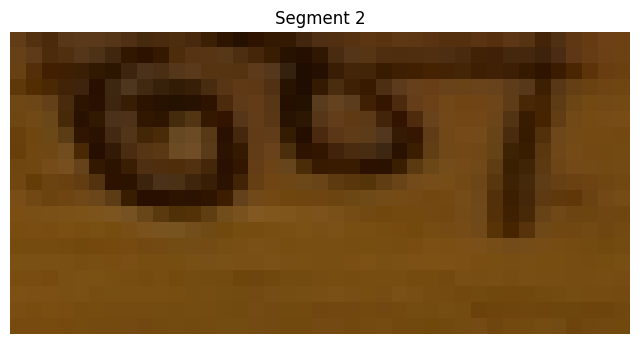

Segment 3 shape: (19, 29, 3)


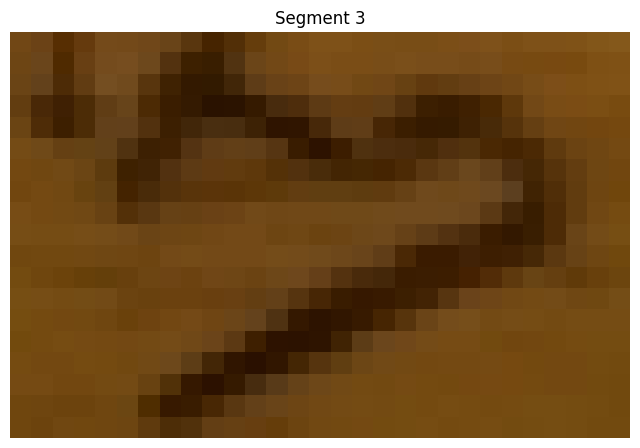

Segment 4 shape: (19, 25, 3)


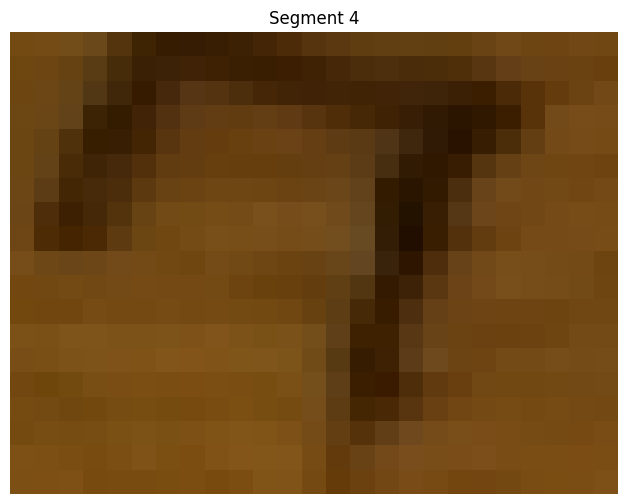

Segment 5 shape: (19, 58, 3)


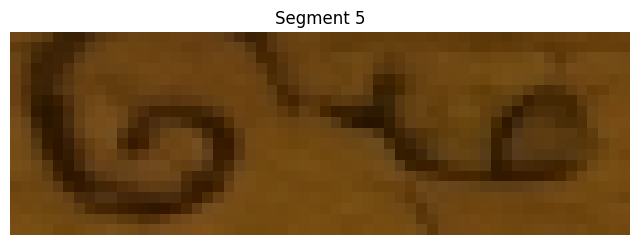

In [19]:
separated_characters_words_original_per_line = []

# MIN_SEGMENT_WIDTH is already defined from the previous cell
# CHAR_SEGMENTATION_THRESHOLD_MULTIPLIER is already defined from the previous cell

for line_idx, line_img_original in enumerate(separated_lines_original):
    # Retrieve the corresponding binary line image
    line_img_binary = separated_lines[line_idx]

    if line_img_binary.shape[1] == 0: # Skip empty lines
        print(f"Skipping empty binary line {line_idx+1}")
        separated_characters_words_original_per_line.append([]) # Append an empty list for this line
        continue

    # Calculate vertical projection profile for the binary image to find segment boundaries
    vertical_projection_binary = np.sum(line_img_binary, axis=0)

    # Determine the threshold for segmentation
    non_zero_projections_binary = vertical_projection_binary[vertical_projection_binary > 0]
    if non_zero_projections_binary.size > 0:
        threshold_for_segmentation = np.mean(non_zero_projections_binary) * CHAR_SEGMENTATION_THRESHOLD_MULTIPLIER
    else:
        threshold_for_segmentation = 0 # No content, so threshold is 0

    current_line_segments_original = []
    is_in_segment = False
    start_col = 0

    for col_idx, value in enumerate(vertical_projection_binary):
        if value > threshold_for_segmentation and not is_in_segment:
            # Start of a new segment
            start_col = col_idx
            is_in_segment = True
        elif value <= threshold_for_segmentation and is_in_segment:
            # End of a segment
            end_col = col_idx - 1
            if (end_col - start_col + 1) >= MIN_SEGMENT_WIDTH:
                # Extract the segment from the original line image
                segment = line_img_original[:, start_col : end_col + 1]
                current_line_segments_original.append(segment)
            is_in_segment = False

    # Handle the case where the last segment extends to the end of the line
    if is_in_segment:
        end_col = len(vertical_projection_binary) - 1
        if (end_col - start_col + 1) >= MIN_SEGMENT_WIDTH:
            segment = line_img_original[:, start_col : end_col + 1]
            current_line_segments_original.append(segment)

    separated_characters_words_original_per_line.append(current_line_segments_original)

print(f"Extracted {len(separated_characters_words_original_per_line)} lines of character/word segments from the original image.")
# Displaying an example of the first few segments from the first line for verification
if separated_characters_words_original_per_line and separated_characters_words_original_per_line[0]:
    print("First few character/word segments from the first line (original image):")
    for i, seg in enumerate(separated_characters_words_original_per_line[0][:5]): # Display up to 5 segments
        print(f'Segment {i+1} shape: {seg.shape}')
        show_img(seg, title=f'Segment {i+1}')

In [ ]:
display_segments_original = [] # To store segments for combined display from original image

# Loop through each line's segmented characters/words
for line_segments_original in separated_characters_words_original_per_line:
    if line_segments_original:
        # Create a white separator (color image as line_img_original is color)
        separator_width = 10
        # Determine the height of the current line's segments for the separator
        # All segments in a line should have the same height, so take the first one.
        segment_height = line_segments_original[0].shape[0]
        separator_original = np.full((segment_height, separator_width, 3), 255, dtype=np.uint8) # 3 channels for color

        combined_segments_image_line_original = []
        for i, segment in enumerate(line_segments_original):
            combined_segments_image_line_original.append(segment)
            if i < len(line_segments_original) - 1:
                combined_segments_image_line_original.append(separator_original)

        if combined_segments_image_line_original:
            display_segments_original.append(np.concatenate(combined_segments_image_line_original, axis=1))

# Now display all the combined line segments from the original image
if display_segments_original:
    # Add a small vertical separator between lines for clarity in the final display
    line_separator_height = 20
    # Find the maximum width among all combined line images for consistent padding
    max_width_original = max([img.shape[1] for img in display_segments_original])
    # Create a white line separator for color images
    line_separator_original = np.full((line_separator_height, max_width_original, 3), 255, dtype=np.uint8)

    final_display_images_original = []
    for i, line_segments_img_original in enumerate(display_segments_original):
        # Pad shorter lines to max_width_original
        if line_segments_img_original.shape[1] < max_width_original:
            padding_width = max_width_original - line_segments_img_original.shape[1]
            padding_original = np.full((line_segments_img_original.shape[0], padding_width, 3), 255, dtype=np.uint8)
            line_segments_img_original = np.concatenate((line_segments_img_original, padding_original), axis=1)

        final_display_images_original.append(line_segments_img_original)
        if i < len(display_segments_original) - 1:
            final_display_images_original.append(line_separator_original)

    combined_all_segments_image_original = np.concatenate(final_display_images_original, axis=0)
    print('\nSegmented Characters/Words (from Original Image):')
    show_img(combined_all_segments_image_original, title='Segments (original)')
else:
    print("No characters or words were segmented from the original image.")


SyntaxError: unterminated string literal (detected at line 44) (995276927.py, line 44)